In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '14/07/2021'
id_noticia = '264461'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[len(tables) - 1] # Last table

In [6]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha

for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL


/tmp/ipykernel_120263/3864133688.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')


,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,56.992,3.953,681,839,54.840,14/07/2021
1,Cádiz,89.732,5.960,667,1.509,82.729,14/07/2021
2,Córdoba,59.418,4.759,588,976,54.718,14/07/2021
3,Granada,95.269,8.428,1.114,1.786,89.324,14/07/2021
4,Huelva,34.835,2.435,182,395,32.633,14/07/2021
5,Jaén,53.732,4.798,456,1.014,50.824,14/07/2021
6,Málaga,115.796,8.605,811,1.683,104.777,14/07/2021
7,Sevilla,141.024,11.197,1.126,2.047,133.134,14/07/2021
8,Total,646.798,50.135,5.625,10.249,602.979,14/07/2021


In [7]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [8]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [9]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [10]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [11]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [12]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [13]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-07-14,62.0,0.0,2.0,131.0,0.0
Cádiz,2021-07-14,157.0,1.0,23.0,415.0,0.0
Córdoba,2021-07-14,187.0,0.0,5.0,299.0,0.0
Granada,2021-07-14,173.0,0.0,7.0,375.0,1.0
Huelva,2021-07-14,85.0,0.0,5.0,159.0,0.0
Jaén,2021-07-14,54.0,0.0,8.0,175.0,0.0
Málaga,2021-07-14,292.0,0.0,33.0,861.0,1.0
Sevilla,2021-07-14,230.0,0.0,34.0,486.0,0.0
Total,2021-07-14,1240.0,1.0,117.0,2901.0,2.0


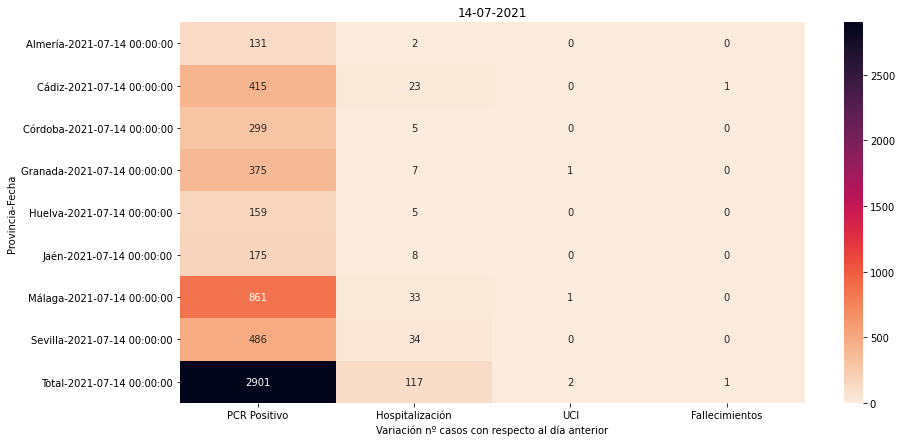

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

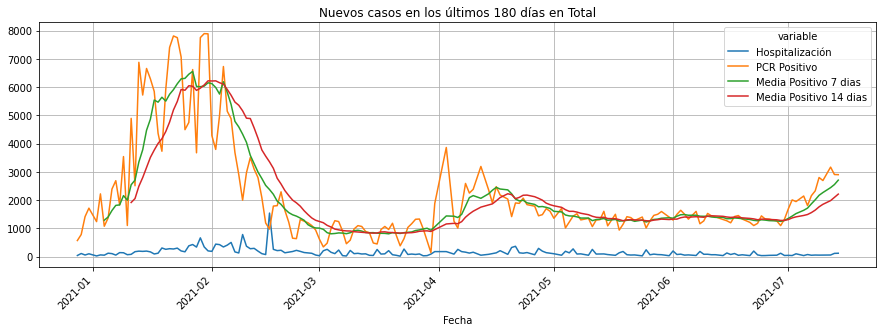

In [15]:
DrawMediaFlotante(df, 'Total', dias_grafico)

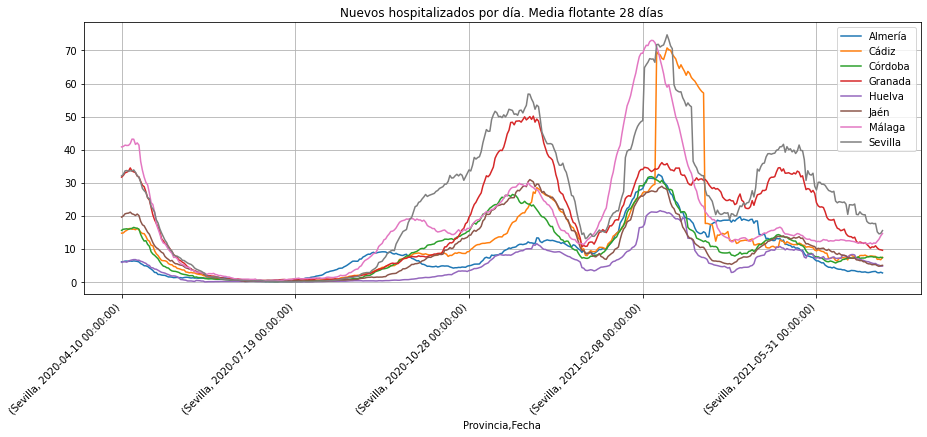

In [16]:
dias = 28
data = dfV['Hospitalización'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Nuevos hospitalizados por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True,legend=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [17]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Hospitalización'], ascending=[False, True])

variable,Fecha,Hospitalización,dias
Provincia,,,
Almería,2021-07-14,2.0,0 days
Huelva,2021-07-14,5.0,0 days
Córdoba,2021-07-14,5.0,0 days
Granada,2021-07-14,7.0,0 days
Jaén,2021-07-14,8.0,0 days
Cádiz,2021-07-14,23.0,0 days
Málaga,2021-07-14,33.0,0 days
Sevilla,2021-07-14,34.0,0 days
Total,2021-07-14,117.0,0 days


In [18]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2021-07-14    65.500000
Cádiz      2021-07-14    18.043478
Córdoba    2021-07-14    59.800000
Granada    2021-07-14    53.571429
Huelva     2021-07-14    31.800000
Jaén       2021-07-14    21.875000
Málaga     2021-07-14    26.090909
Sevilla    2021-07-14    14.294118
Total      2021-07-14    24.794872
dtype: float64

In [19]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'UCI'], ascending=[False, True])

variable,Fecha,UCI,dias
Provincia,,,
Córdoba,2021-07-06,1.0,8 days
Jaén,2021-07-07,1.0,7 days
Huelva,2021-07-07,1.0,7 days
Sevilla,2021-07-07,3.0,7 days
Cádiz,2021-07-09,1.0,5 days
Almería,2021-07-09,1.0,5 days
Málaga,2021-07-14,1.0,0 days
Granada,2021-07-14,1.0,0 days
Total,2021-07-14,2.0,0 days


In [20]:
# Fecha de último Fallecimiento
data = df[['Fallecimientos']].diff()
data = data[data['Fallecimientos'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Fallecimientos'], ascending=[False, True])

variable,Fecha,Fallecimientos,dias
Provincia,,,
Huelva,2021-07-02,1.0,12 days
Córdoba,2021-07-06,2.0,8 days
Almería,2021-07-07,2.0,7 days
Sevilla,2021-07-13,1.0,1 days
Málaga,2021-07-13,1.0,1 days
Jaén,2021-07-13,1.0,1 days
Granada,2021-07-13,1.0,1 days
Total,2021-07-14,1.0,0 days
Cádiz,2021-07-14,1.0,0 days


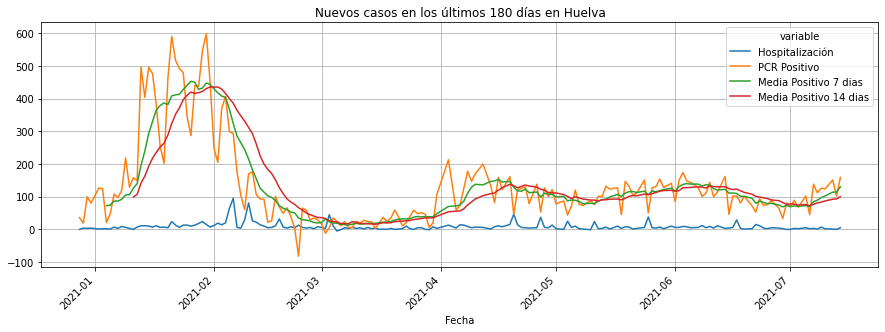

In [21]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

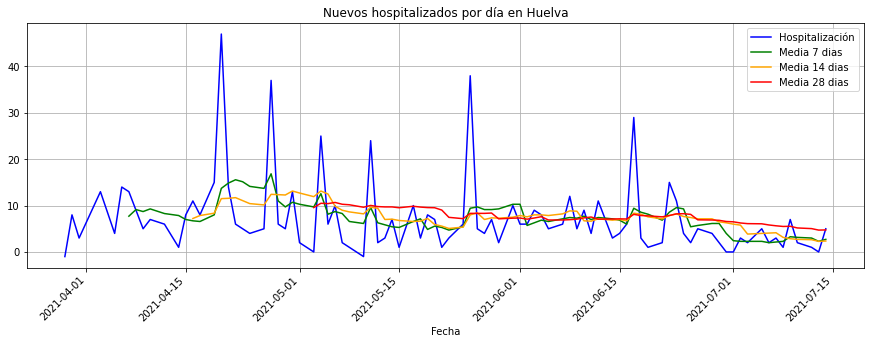

In [22]:
data = pd.DataFrame(dfV.loc['Huelva']['Hospitalización'].tail(90).copy())
data.columns = ['Hospitalización']
data['Media 7 dias'] = data['Hospitalización'].rolling(window=7).mean()
data['Media 14 dias'] = data['Hospitalización'].rolling(window=14).mean()
data['Media 28 dias'] = data['Hospitalización'].rolling(window=28).mean()
data.plot(title='Nuevos hospitalizados por día en Huelva', figsize=(15,5), grid=True, color = ['blue', 'green', 'orange', 'red'])
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

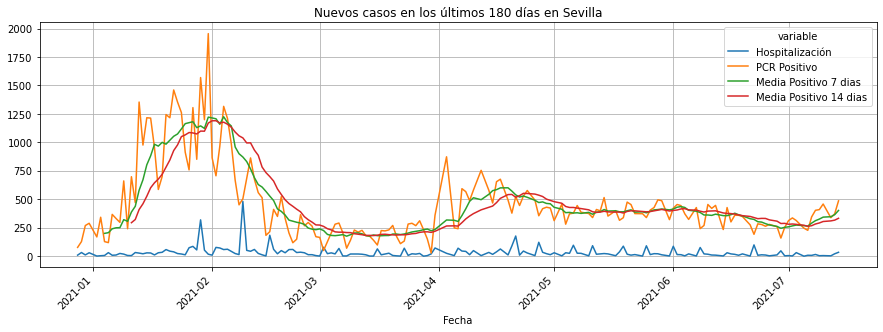

In [23]:
DrawMediaFlotante(df, 'Sevilla', dias_grafico)

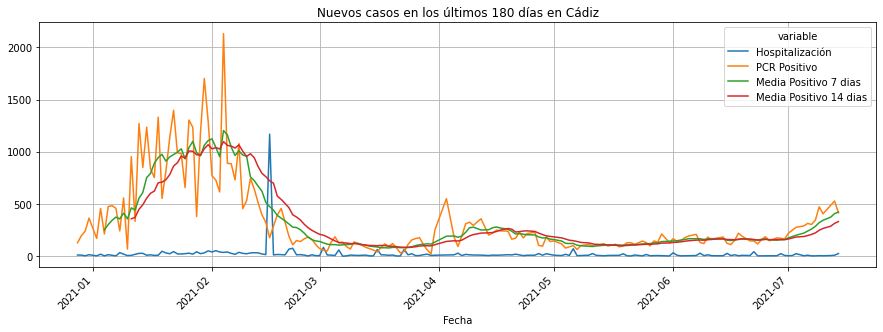

In [24]:
DrawMediaFlotante(df, 'Cádiz', dias_grafico)

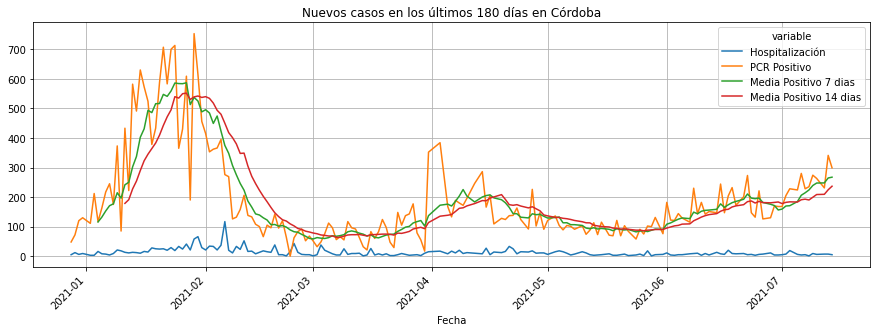

In [25]:
DrawMediaFlotante(df, 'Córdoba', dias_grafico)

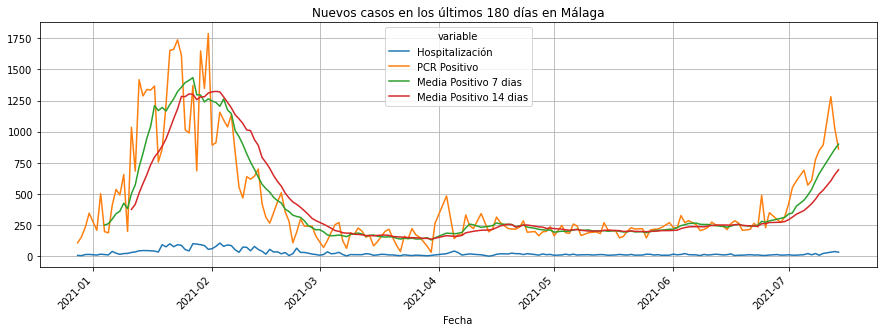

In [26]:
DrawMediaFlotante(df, 'Málaga', dias_grafico)

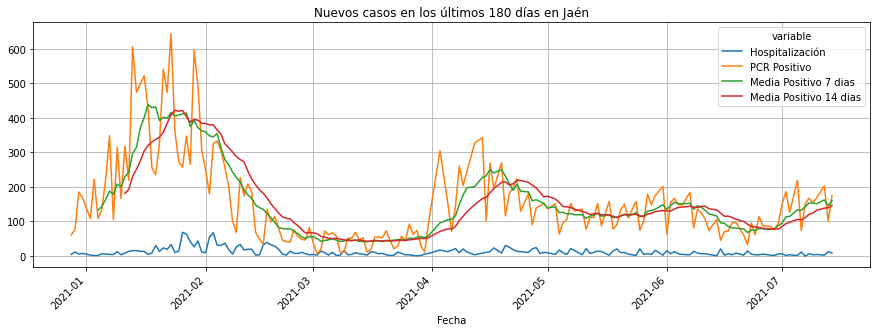

In [27]:
DrawMediaFlotante(df, 'Jaén', dias_grafico)

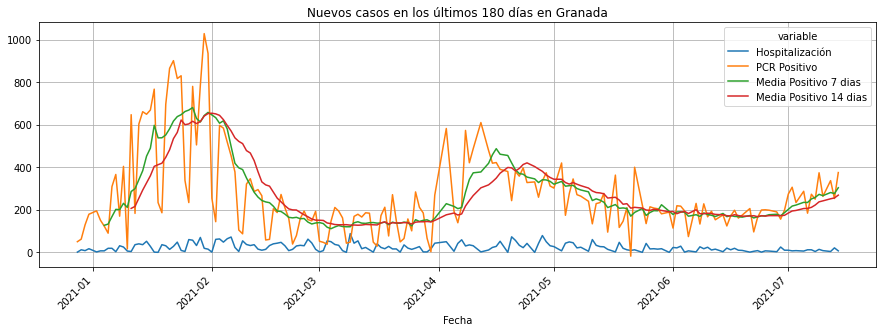

In [28]:
DrawMediaFlotante(df, 'Granada', dias_grafico)

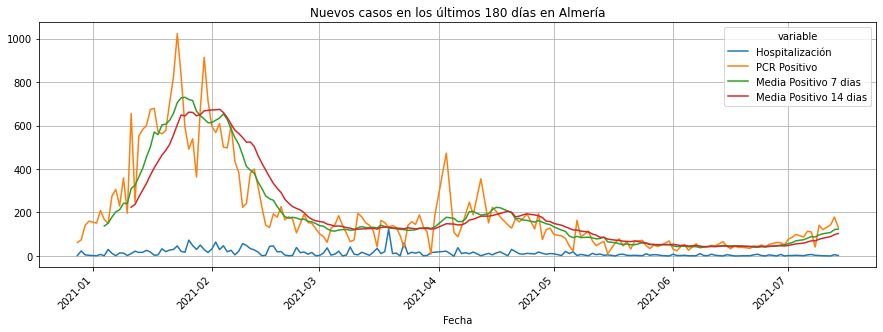

In [29]:
DrawMediaFlotante(df, 'Almería', dias_grafico)